Реализуйте нейронную сеть с двумя сверточными слоями, и одним полносвязным с нейронами с кусочно-линейной функцией активации.

очистка от битых картинок

In [3]:
import os
import shutil
from PIL import Image, UnidentifiedImageError

def clean_notmnist(src_root: str, dst_root: str):
    os.makedirs(dst_root, exist_ok=True)

    classes = sorted(os.listdir(src_root))
    for cls in classes:
        src_dir = os.path.join(src_root, cls)
        dst_dir = os.path.join(dst_root, cls)
        os.makedirs(dst_dir, exist_ok=True)

        for fname in os.listdir(src_dir):
            src_path = os.path.join(src_dir, fname)
            dst_path = os.path.join(dst_dir, fname)
            try:
                # Проверяем, что файл действительно открывается как изображение
                with Image.open(src_path) as img:
                    img.verify()
                shutil.copy2(src_path, dst_path)
            except (UnidentifiedImageError, OSError):
                print("Skipping corrupted:", src_path)

# Использование:
# укажи путь к исходному датасету и папку для чистого
clean_notmnist("notMNIST_large", "notMNIST_clean")

Skipping corrupted: notMNIST_large\A\RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png
Skipping corrupted: notMNIST_large\A\SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png
Skipping corrupted: notMNIST_large\A\Um9tYW5hIEJvbGQucGZi.png
Skipping corrupted: notMNIST_large\B\TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png
Skipping corrupted: notMNIST_large\D\VHJhbnNpdCBCb2xkLnR0Zg==.png


In [4]:
import os
import shutil
from PIL import Image, UnidentifiedImageError

def clean_notmnist(src_root: str, dst_root: str):
    os.makedirs(dst_root, exist_ok=True)

    classes = sorted(os.listdir(src_root))
    for cls in classes:
        src_dir = os.path.join(src_root, cls)
        dst_dir = os.path.join(dst_root, cls)
        os.makedirs(dst_dir, exist_ok=True)

        for fname in os.listdir(src_dir):
            src_path = os.path.join(src_dir, fname)
            dst_path = os.path.join(dst_dir, fname)
            try:
                # Проверяем, что файл действительно открывается как изображение
                with Image.open(src_path) as img:
                    img.verify()
                shutil.copy2(src_path, dst_path)
            except (UnidentifiedImageError, OSError):
                print("Skipping corrupted:", src_path)

# Использование:
# укажи путь к исходному датасету и папку для чистого
clean_notmnist("notMNIST_small", "notMNIST_clean_small")

Skipping corrupted: notMNIST_small\A\RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
Skipping corrupted: notMNIST_small\F\Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import Image, UnidentifiedImageError

# Трансформации: тензоризация + нормализация
transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


# Загрузка датасета (структура папок: train/A, train/B, ..., test/A, ...)
train_dataset = datasets.ImageFolder(root="notMNIST_clean", transform=transform)
test_dataset = datasets.ImageFolder(root="notMNIST_clean_small", transform=transform)


train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Кусочно-линейная активация (пример: LeakyReLU)
class PLU(nn.Module):
    def forward(self, x):
        return torch.where(x >= 0, x, 0.1 * x)

# Модель: 2 Conv + 1 FC
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 10)  # 10 классов
        self.plu = PLU()

    def forward(self, x):
        x = F.max_pool2d(self.plu(self.conv1(x)), 2)
        x = F.max_pool2d(self.plu(self.conv2(x)), 2)
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x

model = Net()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Цикл обучения
for epoch in range(5):
    model.train()
    for data, target in train_loader:
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, loss={loss.item():.4f}")

# Оценка
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for data, target in test_loader:
        output = model(data)
        pred = output.argmax(dim=1)
        correct += (pred == target).sum().item()
        total += target.size(0)

print(f"Test accuracy: {correct/total:.4f}")


Epoch 1, loss=0.7934
Epoch 2, loss=0.7177
Epoch 3, loss=0.1342
Epoch 4, loss=0.2368
Epoch 5, loss=0.4906
Test accuracy: 0.9607


Какова точность построенной модели?
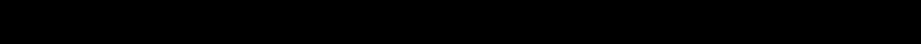

Замените сверточные слои на слои, реализующие операцию пулинга (Pooling) с функцией максимума или среднего. Как это повлияло на точность классификатора?
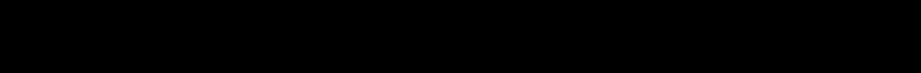

Using device: cpu
